## Detecting Jamming Attacks in VANET DSRC Communications with Machine Learning

Course: ITCS 3156 – Machine Learning  
Author: *Trey Stull*  
Dataset: DSRC / VANET normal vs jammer communication logs  

This notebook builds an end-to-end machine learning pipeline to distinguish
between **normal** DSRC (Dedicated Short Range Communications) traffic and
traffic affected by a **jamming attack** in a Vehicular Ad-Hoc Network (VANET).

## Final Project step-by-step breakdown: 

1. Parse the raw VANET simulation logs from text files inside a ZIP archive.
2. Construct a tabular dataset of individual transmission/reception events.
3. Explore and visualize the data (class balance, key features like RSS/SNR).
4. Build and evaluate at least two ML algorithms (ex., Logistic Regression, Support Vector Machine - SVM).
5. Analyze the results and discuss how well the models detect jamming.


In [1]:
# Core numerical / data libraries
import numpy as np
import pandas as pd

# Working with the ZIP archive and text parsing
import zipfile
import re
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Make plots a bit nicer by default
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

# For later ML steps (we'll use these in the Methods / Results sections)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # SVM instead of Random Forest

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports complete.")


Imports complete.


In [2]:
# Path to the VANET dataset ZIP file.
ZIP_PATH = Path("dsrc+vehicle+communications.zip")

assert ZIP_PATH.exists(), f"ZIP file not found at {ZIP_PATH.resolve()}"

with zipfile.ZipFile(ZIP_PATH) as z:
    files = z.namelist()

# Separate normal and jammer log files (only .txt, not the Excel summaries)
normal_members = [
    f for f in files
    if f.startswith("VANET dataset/Normal/") and f.endswith(".txt")
]
jammer_members = [
    f for f in files
    if f.startswith("VANET dataset/Jammer/") and f.endswith(".txt")
]

print("Normal log files:")
for f in normal_members:
    print("  ", f)

print("\nJammer log files:")
for f in jammer_members:
    print("  ", f)


Normal log files:
   VANET dataset/Normal/1 OBU.txt
   VANET dataset/Normal/10 OBU.txt
   VANET dataset/Normal/100 OBU.txt
   VANET dataset/Normal/20 OBU.txt
   VANET dataset/Normal/40 OBU.txt
   VANET dataset/Normal/60 OBU.txt
   VANET dataset/Normal/80 OBU.txt

Jammer log files:
   VANET dataset/Jammer/1 OBU w jammer.txt
   VANET dataset/Jammer/10 OBU w jammer.txt
   VANET dataset/Jammer/100 OBU w jammer.txt
   VANET dataset/Jammer/20 OBU w jammer.txt
   VANET dataset/Jammer/40 OBU w jammer.txt
   VANET dataset/Jammer/60 OBU w jammer.txt
   VANET dataset/Jammer/80 OBU w jammer.txt


In [3]:
def parse_vanet_log_from_zip(zip_path: Path, member_name: str, label: int) -> pd.DataFrame:
    """
    Parse a single VANET simulation log (.txt) from inside the ZIP archive
    into a pandas DataFrame.

    Each row in the returned DataFrame represents one TX/RX event with:
        - time  : simulation time in seconds
        - TXnid : transmitter node ID
        - RXnid : receiver node ID
        - RSS   : received signal strength (dB)
        - SNR   : signal-to-noise ratio (dB)
        - label : 0 = normal, 1 = jammer (supplied argument)

    Parameters
    ----------
    zip_path : Path
        Path to the ZIP archive.
    member_name : str
        Internal path to the text file inside the ZIP.
    label : int
        Class label for this scenario: 0 for normal, 1 for jammer.

    Returns
    -------
    df : pd.DataFrame
        Parsed events with columns [time, TXnid, RXnid, RSS, SNR, label].
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(member_name) as f:
            text = f.read().decode(errors="ignore")

    lines = text.splitlines()
    data = []
    current_time = None

    # Time lines examples:
    # "Current Time:    1.00 sec   ..."
    # "     12      500      0.100000      1.100000"
    current_time_re = re.compile(r"Current Time:\s*([\d\.]+)\s*sec")
    block_time_re = re.compile(r"^\s*\d+\s+\d+\s+([\d\.]+)\s+([\d\.]+)")

    # TX/RX lines example:
    # "TXnid = 2       RXnid = 3       RSS = -58.698546        SNR = 45.301454"
    tx_re = re.compile(
        r"TXnid\s*=\s*(\d+)\s+"
        r"RXnid\s*=\s*(\d+)\s+"
        r"RSS\s*=\s*([-+]?\d+\.\d+)\s+"
        r"SNR\s*=\s*([-+]?\d+\.\d+)"
    )

    for line in lines:
        # Update current_time when we see a time line
        m_curr = current_time_re.search(line)
        if m_curr:
            current_time = float(m_curr.group(1))

        m_block = block_time_re.search(line)
        if m_block:
            # Last float in that line behaves like the timestamp (e.g., 1.1, 1.2, ...)
            current_time = float(m_block.group(2))

        # Extract a TX/RX event with RSS/SNR
        m_tx = tx_re.search(line)
        if m_tx:
            txnid = int(m_tx.group(1))
            rxnid = int(m_tx.group(2))
            rss   = float(m_tx.group(3))
            snr   = float(m_tx.group(4))
            data.append((current_time, txnid, rxnid, rss, snr, label))

    df = pd.DataFrame(
        data,
        columns=["time", "TXnid", "RXnid", "RSS", "SNR", "label"]
    )
    return df

In [4]:
dfs = []

# Parse all normal scenarios (label = 0)
for member in normal_members:
    df = parse_vanet_log_from_zip(ZIP_PATH, member, label=0)
    df["scenario"] = "normal"

    # Extract the number of OBUs from the filename (e.g., "40 OBU.txt" -> 40)
    match = re.search(r"(\d+)\s*OBU", member)
    df["OBU_count"] = int(match.group(1)) if match else np.nan

    dfs.append(df)

# Parse all jammer scenarios (label = 1)
for member in jammer_members:
    df = parse_vanet_log_from_zip(ZIP_PATH, member, label=1)
    df["scenario"] = "jammer"

    match = re.search(r"(\d+)\s*OBU", member)
    df["OBU_count"] = int(match.group(1)) if match else np.nan

    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

print("Combined dataset shape:", full_df.shape)
full_df.head()

Combined dataset shape: (1835837, 8)


,time,TXnid,RXnid,RSS,SNR,label,scenario,OBU_count
0,1.00005,2,3,-65.386945,38.613055,0,normal,1
1,1.00005,2,1,-75.130384,28.869616,0,normal,1
2,1.00005,2,3,-79.037043,24.962957,0,normal,1
3,1.00005,2,1,-72.854750,31.145250,0,normal,1
4,1.00005,2,3,-68.748605,35.251395,0,normal,1


In [5]:
# Feature engineering: create additional RSS/SNR-based features

eps = 1e-6  # small value to avoid divide-by-zero

full_df["RSS_minus_SNR"] = full_df["RSS"] - full_df["SNR"]
full_df["RSS_div_SNR"]   = full_df["RSS"] / (full_df["SNR"] + eps)
full_df["RSS_squared"]   = full_df["RSS"] ** 2
full_df["SNR_squared"]   = full_df["SNR"] ** 2

# Optional: quick check
full_df[["RSS", "SNR", "RSS_minus_SNR", "RSS_div_SNR", "RSS_squared", "SNR_squared"]].head()

,RSS,SNR,RSS_minus_SNR,RSS_div_SNR,RSS_squared,SNR_squared
0,-65.386945,38.613055,-104.0,-1.693390,4275.452576,1490.968016
1,-75.130384,28.869616,-104.0,-2.602403,5644.574600,833.454728
2,-79.037043,24.962957,-104.0,-3.166173,6246.854166,623.149222
3,-72.854750,31.145250,-104.0,-2.339193,5307.814598,970.026598
4,-68.748605,35.251395,-104.0,-1.950238,4726.370689,1242.660849


In [6]:
# Basic info about the dataset

print("Info:\n")
full_df.info()

print("\nSummary statistics (numeric columns):\n")
display(full_df.describe())

print("\nClass distribution (0 = normal, 1 = jammer):")
print(full_df["label"].value_counts())
print("\nClass distribution (percent):")
print(full_df["label"].value_counts(normalize=True) * 100)

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1835837 entries, 0 to 1835836
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           float64
 1   TXnid          int64  
 2   RXnid          int64  
 3   RSS            float64
 4   SNR            float64
 5   label          int64  
 6   scenario       object 
 7   OBU_count      int64  
 8   RSS_minus_SNR  float64
 9   RSS_div_SNR    float64
 10  RSS_squared    float64
 11  SNR_squared    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 168.1+ MB

Summary statistics (numeric columns):



,time,TXnid,RXnid,RSS,SNR,label,OBU_count,RSS_minus_SNR,RSS_div_SNR,RSS_squared,SNR_squared
count,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06,1.835837e+06
mean,1.478737e+01,2.358167e+01,2.846355e+01,-6.434852e+01,4.409152e+01,1.480012e-01,5.311335e+01,-1.084400e+02,-1.753775e+00,4.272456e+03,2.254076e+03
std,8.284924e+00,1.750780e+01,1.916888e+01,1.147713e+01,1.760723e+01,3.551012e-01,1.928157e+01,1.065304e+01,6.533152e+00,1.385435e+03,1.989869e+03
min,1.000000e+00,2.000000e+00,1.000000e+00,-1.248972e+02,-2.089719e+01,0.000000e+00,1.000000e+00,-1.340000e+02,-4.911612e+03,5.324095e-04,4.105081e-04
25%,7.400050e+00,7.000000e+00,1.200000e+01,-7.242807e+01,3.210984e+01,0.000000e+00,4.000000e+01,-1.040000e+02,-2.239004e+00,3.341544e+03,1.031042e+03
50%,1.460005e+01,2.100000e+01,2.600000e+01,-6.643008e+01,3.892085e+01,0.000000e+00,6.000000e+01,-1.040000e+02,-1.673919e+00,4.412956e+03,1.514832e+03
75%,2.200000e+01,3.700000e+01,4.100000e+01,-5.780609e+01,5.098306e+01,0.000000e+00,6.000000e+01,-1.040000e+02,-1.121989e+00,5.245825e+03,2.599272e+03
max,2.992000e+01,6.200000e+01,1.020000e+02,4.201654e+01,1.504738e+02,1.000000e+00,1.000000e+02,-1.040000e+02,5.134268e+03,1.559931e+04,2.264237e+04



Class distribution (0 = normal, 1 = jammer):
label
0    1564131
1     271706
Name: count, dtype: int64

Class distribution (percent):
label
0    85.199884
1    14.800116
Name: proportion, dtype: float64


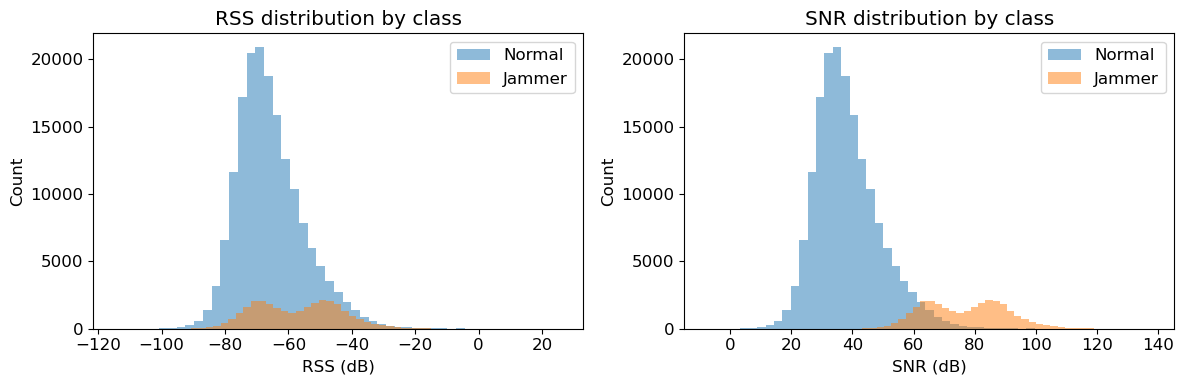

In [7]:
# Histogram of RSS and SNR by class

plot_sample = full_df.sample(n=min(200_000, len(full_df)), random_state=RANDOM_STATE)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for lbl, name, color in [(0, "Normal", "tab:blue"), (1, "Jammer", "tab:orange")]:
    subset = plot_sample[plot_sample["label"] == lbl]
    axes[0].hist(subset["RSS"], bins=50, alpha=0.5, label=name)
    axes[1].hist(subset["SNR"], bins=50, alpha=0.5, label=name)

axes[0].set_title("RSS distribution by class")
axes[0].set_xlabel("RSS (dB)")
axes[0].set_ylabel("Count")

axes[1].set_title("SNR distribution by class")
axes[1].set_xlabel("SNR (dB)")
axes[1].set_ylabel("Count")

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
# Train/Test Split (Stratified to preserve class ratios)

feature_cols = [
    "RSS",
    "SNR",
    "RSS_minus_SNR",
    "RSS_div_SNR",
    "RSS_squared",
    "SNR_squared",
]

X = full_df[feature_cols].values
y = full_df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 1468669
Testing samples: 367168


In [9]:
#Downsample training set for faster SVM training

train_fraction = 0.01   # 1% of training data (~15,000 samples)

np.random.seed(RANDOM_STATE)

train_sample_idx = np.random.choice(
    len(X_train),
    size=int(len(X_train) * train_fraction),
    replace=False
)

X_train_small = X_train[train_sample_idx]
y_train_small = y_train[train_sample_idx]

print("Original training size:", len(X_train))
print("Reduced training size:", len(X_train_small))


Original training size: 1468669
Reduced training size: 14686


In [10]:
# Standardize features (important for LR & SVM)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")


Scaling complete.


                    |Logistic Regression Results|
 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    312827
           1     0.9998    1.0000    0.9999     54341

    accuracy                         1.0000    367168
   macro avg     0.9999    1.0000    0.9999    367168
weighted avg     1.0000    1.0000    1.0000    367168



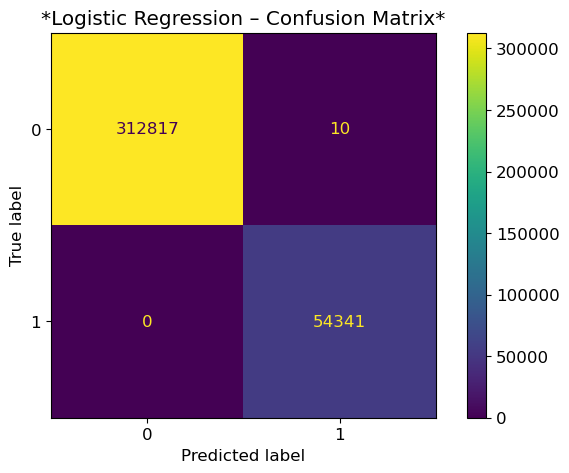

In [11]:
# Logistic Regression Model

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train_small)
y_pred_lr = log_reg.predict(X_test_scaled)

print("                    |Logistic Regression Results|")
print(" ")
print(classification_report(y_test, y_pred_lr, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("*Logistic Regression – Confusion Matrix*")
plt.show()


                           |SVM Results|
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    312827
           1     1.0000    0.9999    1.0000     54341

    accuracy                         1.0000    367168
   macro avg     1.0000    1.0000    1.0000    367168
weighted avg     1.0000    1.0000    1.0000    367168



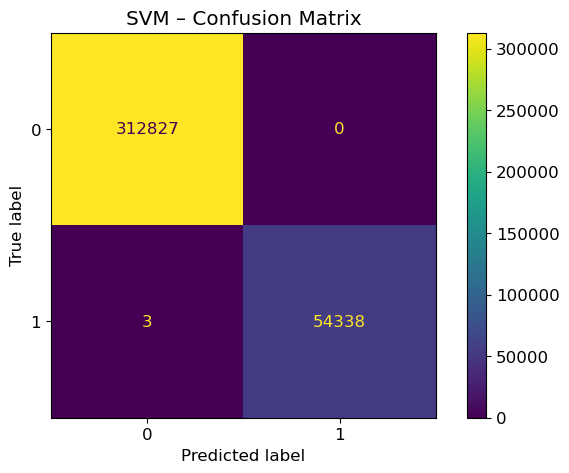

In [12]:
# Support Vector Machine (RBF Kernel)

svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    C=1.0,
    gamma="scale"
)

svm.fit(X_train_scaled, y_train_small)
y_pred_svm = svm.predict(X_test_scaled)

print("                           |SVM Results|")
print(classification_report(y_test, y_pred_svm, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("SVM – Confusion Matrix")
plt.show()

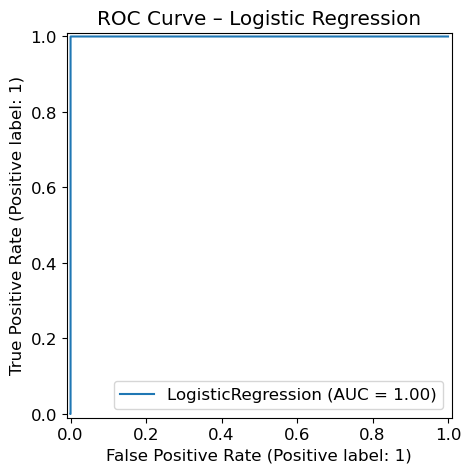

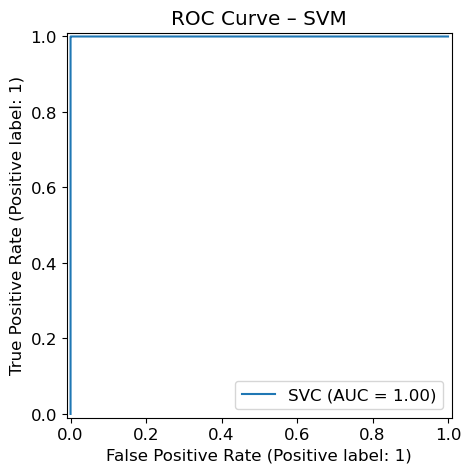

In [13]:
# ROC Curves for Both Models

RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("ROC Curve – Logistic Regression")
plt.show()

RocCurveDisplay.from_estimator(svm, X_test_scaled, y_test)
plt.title("ROC Curve – SVM")
plt.show()

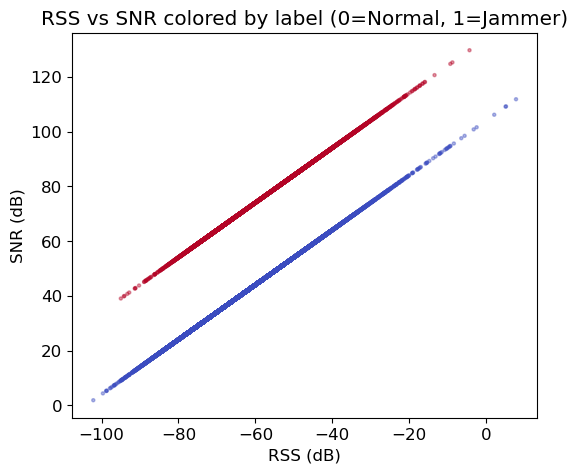

In [14]:
sample = full_df.sample(n=50_000, random_state=42)

plt.figure(figsize=(6,5))
plt.scatter(sample["RSS"], sample["SNR"], c=sample["label"], s=5, alpha=0.4, cmap="coolwarm")
plt.xlabel("RSS (dB)")
plt.ylabel("SNR (dB)")
plt.title("RSS vs SNR colored by label (0=Normal, 1=Jammer)")
plt.show()

In [15]:
from sklearn.utils import shuffle as sk_shuffle

y_shuffled = sk_shuffle(y_train_small, random_state=42)

log_reg_shuffled = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg_shuffled.fit(X_train_scaled, y_shuffled)
y_pred_shuffle = log_reg_shuffled.predict(X_test_scaled)

print(classification_report(y_test, y_pred_shuffle, digits=4))

              precision    recall  f1-score   support

           0     0.6244    0.2599    0.3670    312827
           1     0.0229    0.0999    0.0373     54341

    accuracy                         0.2362    367168
   macro avg     0.3236    0.1799    0.2021    367168
weighted avg     0.5353    0.2362    0.3182    367168

